In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle
import yaml
import pandas as pd
import os
import getdist
from getdist import plots, MCSamples
import sacc
import pacc
import random
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rc('legend',fontsize=18)
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.10.0


## Load Data

In [2]:
s_wlwl = sacc.Sacc.load_fits("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y_wlwl = yaml.load(open("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/wlwl.yml"), Loader=yaml.FullLoader)

s_gcgc = sacc.Sacc.load_fits("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y_gcgc = yaml.load(open("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc.yml"), Loader=yaml.FullLoader)

s_3x2 = sacc.Sacc.load_fits("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y_3x2 = yaml.load(open("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

In [34]:
method = "bpz"
nz_path = "./data/CosmoDC2/image_gp_" +  method + "_priors/"
nzs = {
"lens_0": np.load(nz_path+"gp_lens_0.npz"),
"lens_1": np.load(nz_path+"gp_lens_1.npz"),
"lens_2": np.load(nz_path+"gp_lens_2.npz"),
"lens_3": np.load(nz_path+"gp_lens_3.npz"),
"lens_4": np.load(nz_path+"gp_lens_4.npz"),
"source_0": np.load(nz_path+"gp_source_0.npz"),
"source_1": np.load(nz_path+"gp_source_1.npz"),
"source_2": np.load(nz_path+"gp_source_2.npz"),
"source_3": np.load(nz_path+"gp_source_3.npz"),
"source_4": np.load(nz_path+"gp_source_4.npz"),
}


In [3]:
cle_3x2  = pacc.ClsEnsemble(s_3x2, y_3x2,   label="CosmoDC2 3x2  - data")
cle_wlwl = pacc.ClsEnsemble(s_wlwl, y_wlwl, label="CosmoDC2 wlwl - data")
cle_gcgc = pacc.ClsEnsemble(s_gcgc, y_gcgc, label="CosmoDC2 gcgc - data")

In [4]:
tpts = np.load("covs/COSMODC2/comp_covs.npz")
tt_dz = np.diag(np.load("covs/COSMODC2/dz_covs.npz")["3x2_AD"])
tt_wzdz = np.diag(np.load("covs/COSMODC2/wzdz_covs.npz")["3x2_AD"])
tt_pca = np.diag(np.load("covs/COSMODC2/PCA_covs.npz")["3x2_AD"])
tt_gp = np.diag(np.load("covs/COSMODC2/gp_covs.npz")["3x2_AD"])
cov = tpts["cov"]
total_l = 0
_tt_dz = []
_tt_wzdz = []
_tt_pca = []
_tt_gp = []
_cov = []
for d in cle_3x2.data:
    dz = tt_dz[total_l:total_l+len(d)]
    wzdz = tt_wzdz[total_l:total_l+len(d)]
    pca = tt_pca[total_l:total_l+len(d)]
    gp = tt_gp[total_l:total_l+len(d)]
    c = cov[total_l:total_l+len(d)]
    _tt_dz.append((dz-c)/c)
    _tt_wzdz.append((wzdz-c)/c)
    _tt_pca.append((pca-c)/c)
    _tt_gp.append((gp-c)/c)
    _cov.append(c)
    total_l += len(d)

cle_3x2_tt_dz = pacc.ClsEnsemble(s_3x2, y_3x2,   label=r"$\delta z$")
cle_3x2_tt_dz.errs = _tt_dz
cle_3x2_tt_wzdz = pacc.ClsEnsemble(s_3x2, y_3x2,   label=r"$w_z \, \delta z$")
cle_3x2_tt_wzdz.errs = _tt_wzdz
cle_3x2_tt_pca = pacc.ClsEnsemble(s_3x2, y_3x2,   label="PCA")
cle_3x2_tt_pca.errs = _tt_pca
cle_3x2_tt_gp = pacc.ClsEnsemble(s_3x2, y_3x2,   label="GP")
cle_3x2_tt_gp.errs = _tt_gp

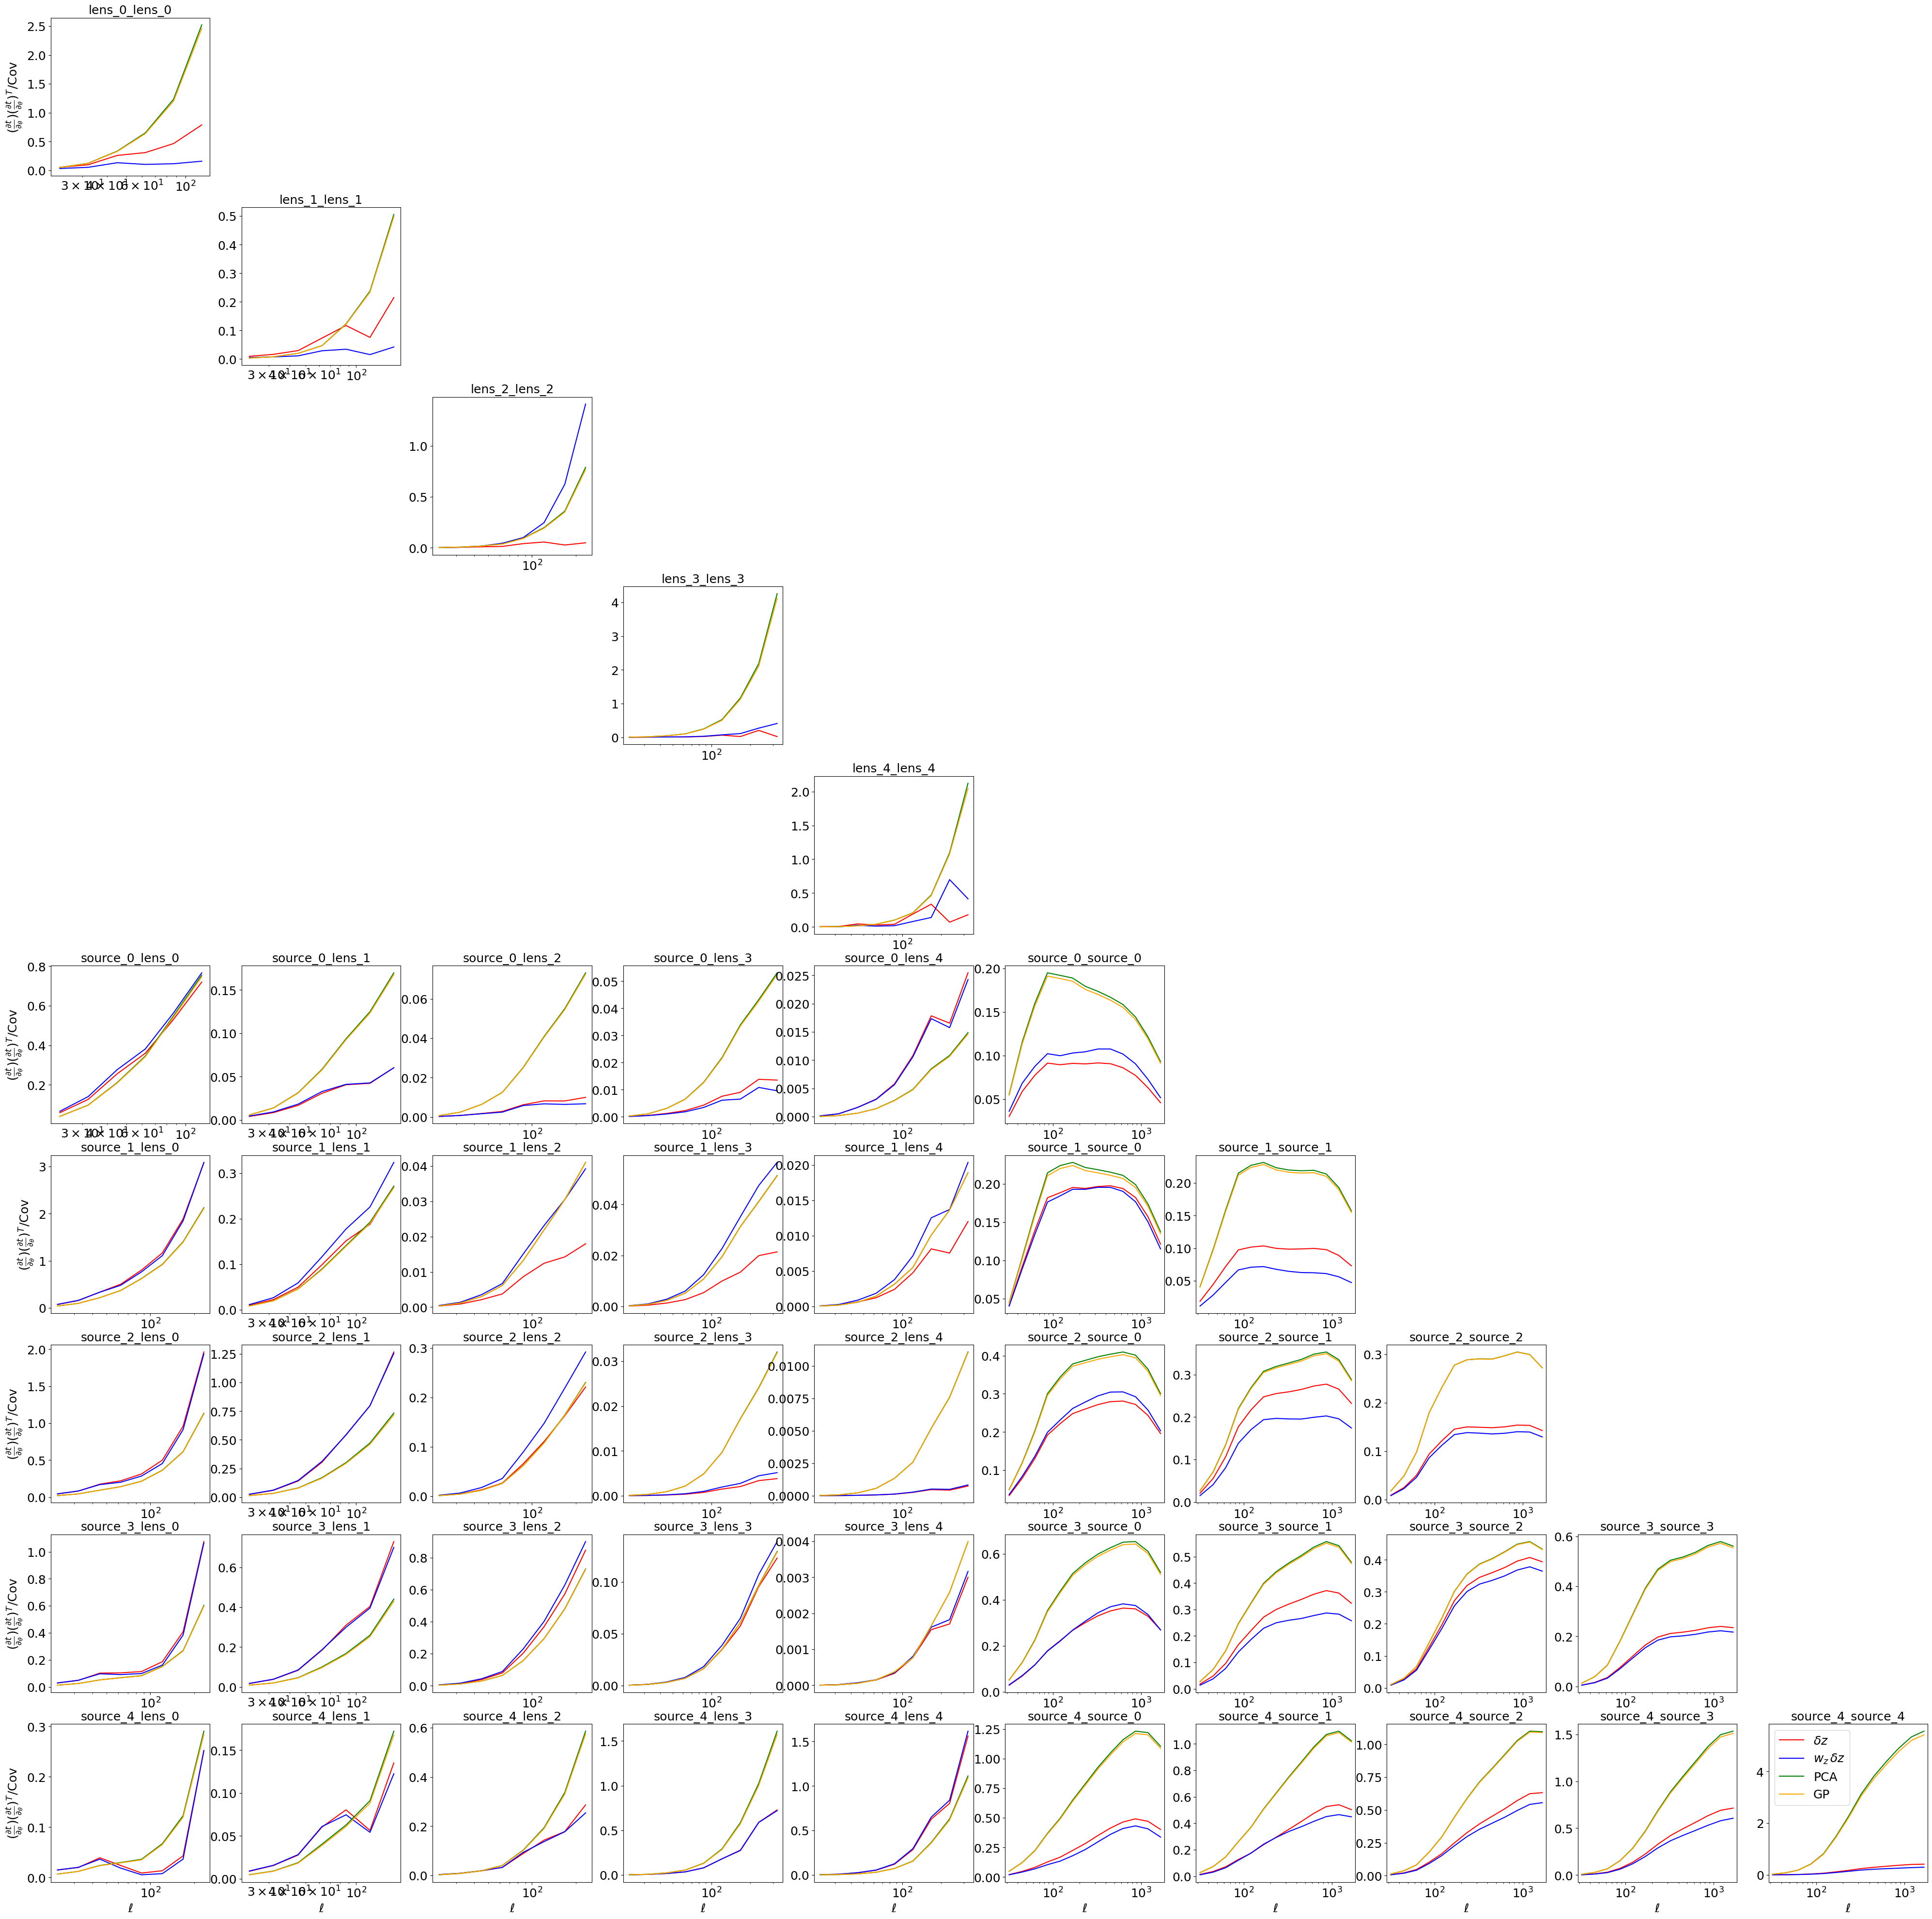

In [5]:
colors = ['r', 'b', 'g', 'orange']
g = pacc.plot_errs([[cle_3x2_tt_dz, cle_3x2_tt_wzdz, cle_3x2_tt_pca, cle_3x2_tt_gp]], cle_3x2.pairs,
               configs=[{'colors': colors},
                        {'colors': colors}, 
                        {'colors': colors}, 
                        {'colors': colors}],);
g.savefig("./paper_plots/tpts_3x2.pdf", bbox_inches='tight')

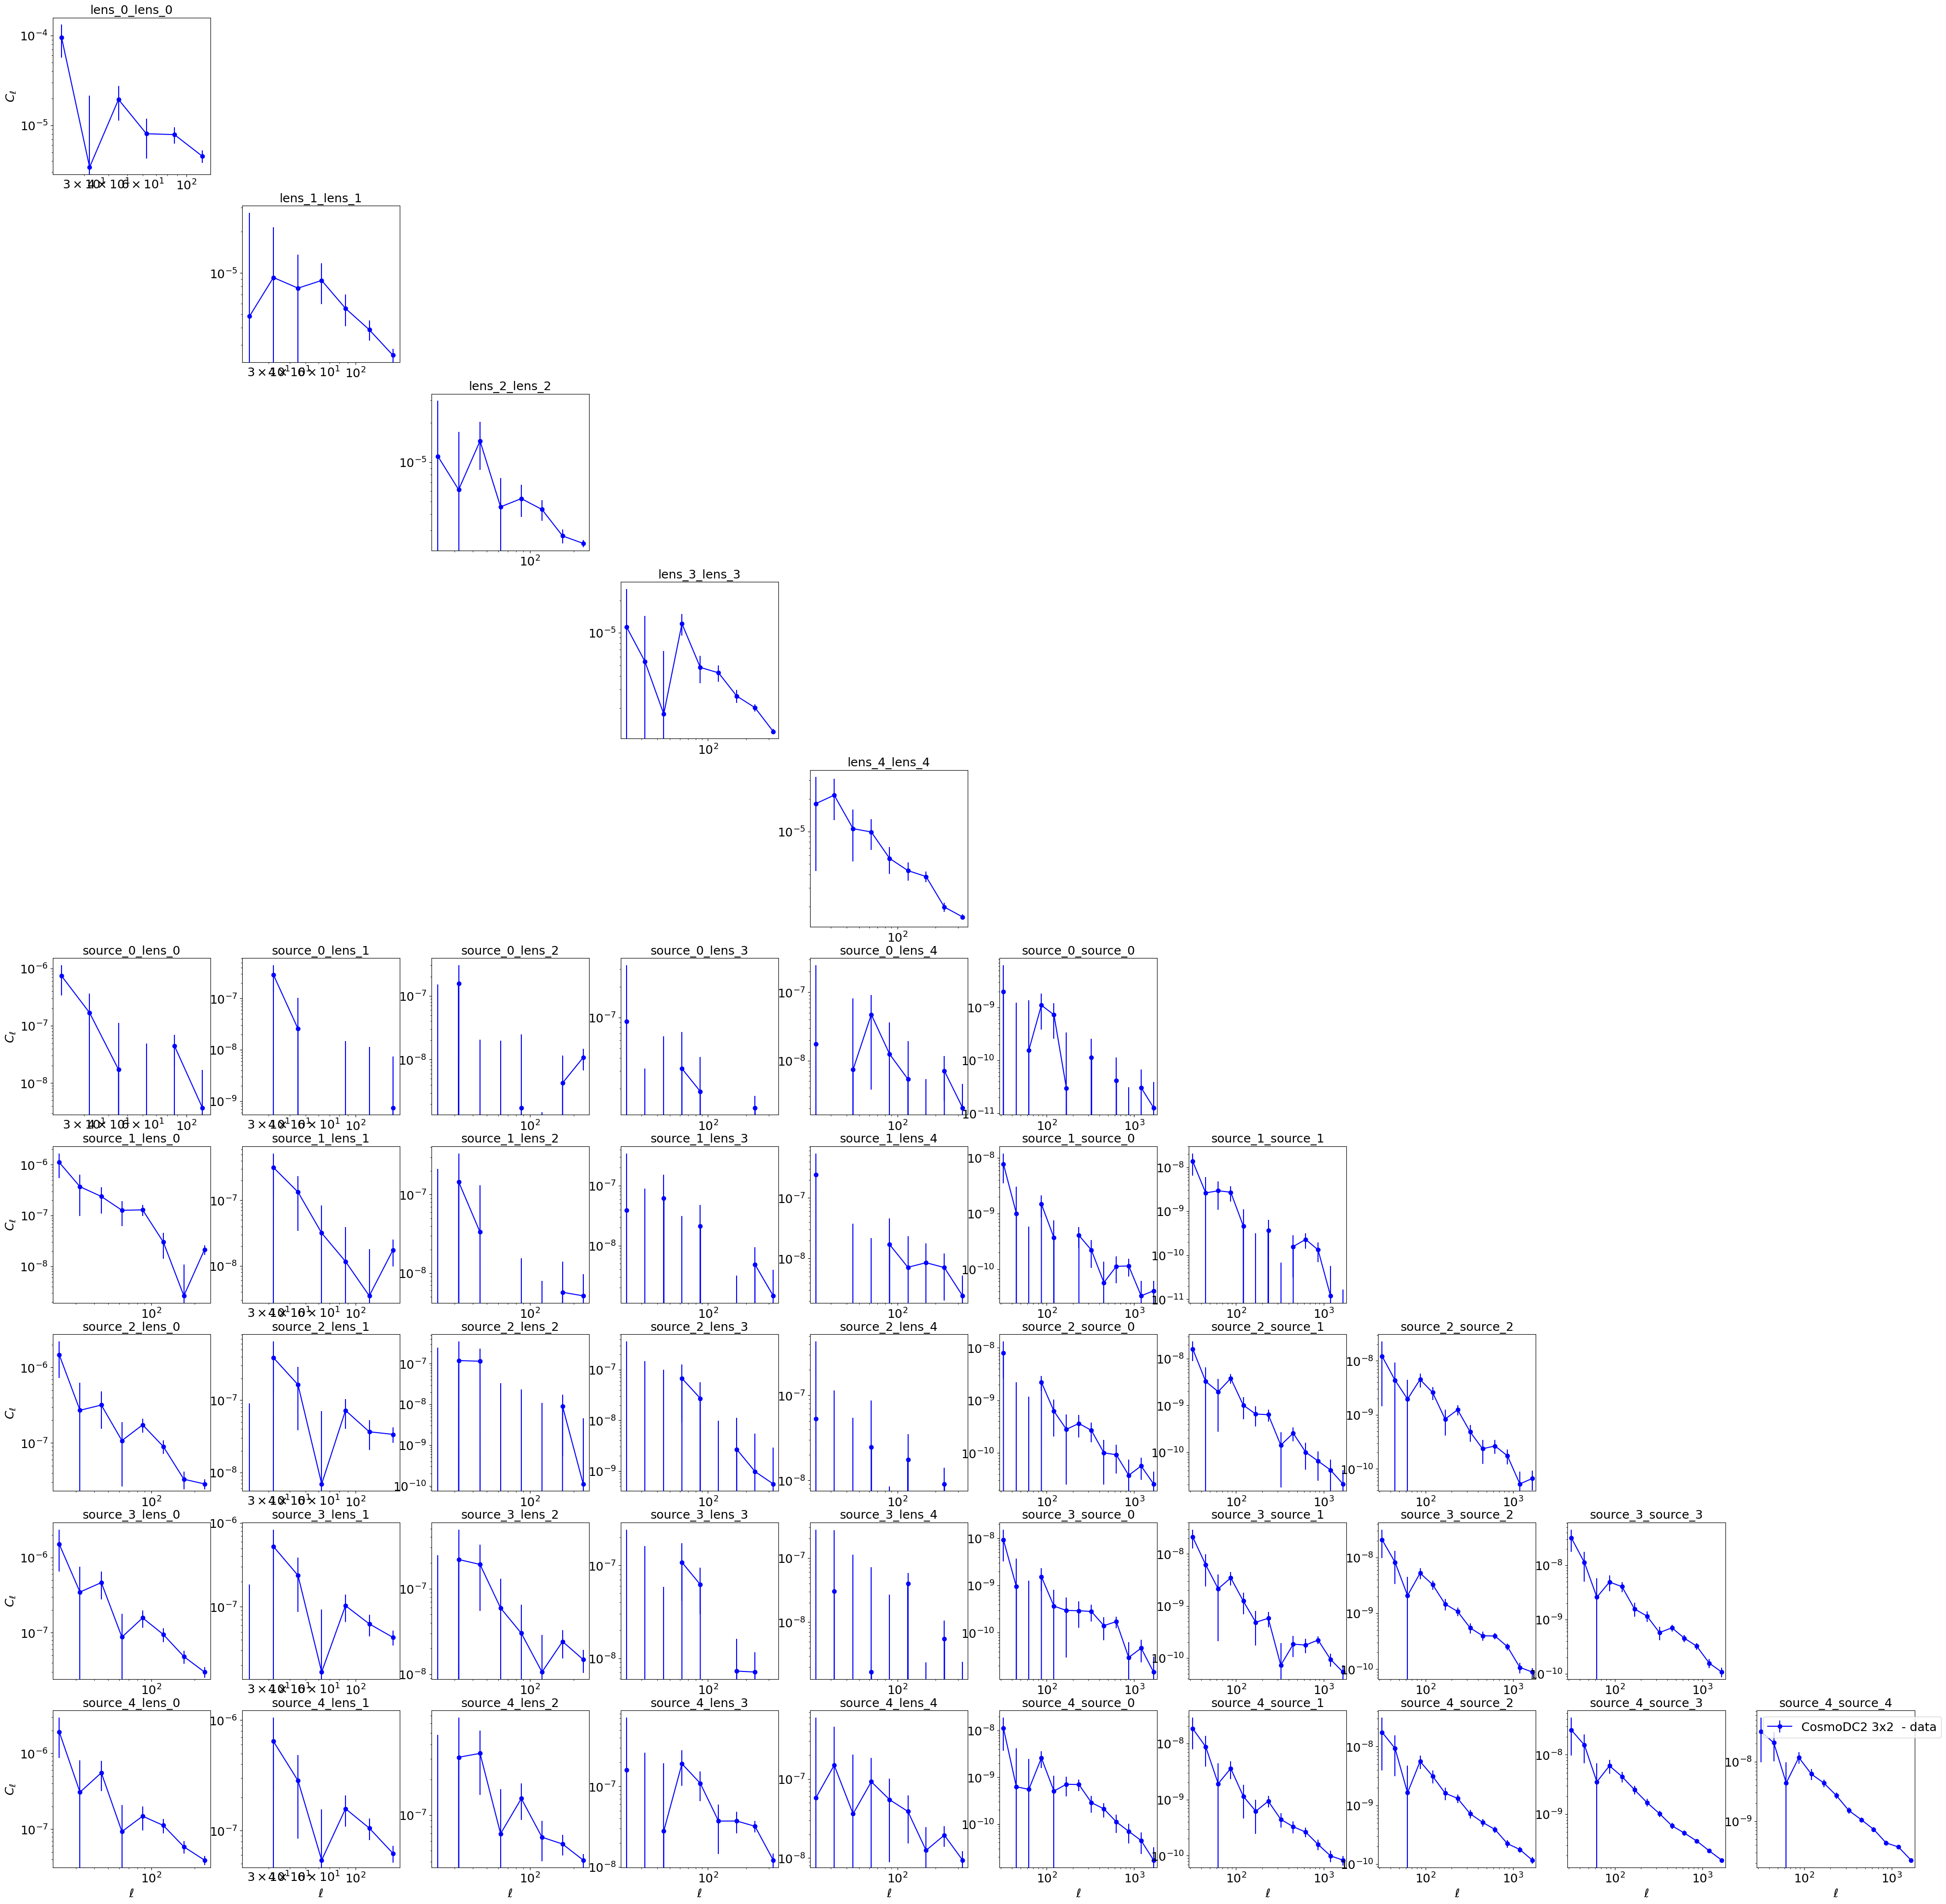

In [6]:
g = pacc.plot_cls([[cle_3x2]], cle_3x2.pairs);
g.savefig("./paper_plots/data_3x2.pdf", bbox_inches='tight')

In [7]:
wzdz_path = "./data/CosmoDC2/image_wzdz_bpz_priors/wzdz_prior.npz"
wzdz_prior = np.load(wzdz_path)
prior_samples = []
for i in range(10_000):
    prior_sample = np.random.multivariate_normal(wzdz_prior["mean"],
                                                wzdz_prior["cov"])
    prior_samples.append(prior_sample)
prior_samples = np.array(prior_samples).T
prior_wzdz_chain = {}
prior_wzdz_chain["dzs_lens[1]"] = prior_samples[0]
prior_wzdz_chain["wzs_lens[1]"] = prior_samples[1]
prior_wzdz_chain["dzs_lens[2]"] = prior_samples[2]
prior_wzdz_chain["wzs_lens[2]"] = prior_samples[3]
prior_wzdz_chain["dzs_lens[3]"] = prior_samples[4]
prior_wzdz_chain["wzs_lens[3]"] = prior_samples[5]
prior_wzdz_chain["dzs_lens[4]"] = prior_samples[6]
prior_wzdz_chain["wzs_lens[4]"] = prior_samples[7]
prior_wzdz_chain["dzs_lens[5]"] = prior_samples[8]
prior_wzdz_chain["wzs_lens[5]"] = prior_samples[9]
prior_wzdz_chain["dzs_source[1]"] = prior_samples[10]
prior_wzdz_chain["wzs_source[1]"] = prior_samples[11]
prior_wzdz_chain["dzs_source[2]"] = prior_samples[12]
prior_wzdz_chain["wzs_source[2]"] = prior_samples[13]
prior_wzdz_chain["dzs_source[3]"] = prior_samples[14]
prior_wzdz_chain["wzs_source[3]"] = prior_samples[15]
prior_wzdz_chain["dzs_source[4]"] = prior_samples[16]
prior_wzdz_chain["wzs_source[4]"] = prior_samples[17]
prior_wzdz_chain["dzs_source[5]"] = prior_samples[18]
prior_wzdz_chain["wzs_source[5]"] = prior_samples[19]


In [8]:
dz_path = "./data/CosmoDC2/image_dz_bpz_priors/dz_prior.npz"
dz_prior = np.load(dz_path)
prior_samples = []
for i in range(10_000):
    prior_sample = np.random.multivariate_normal(dz_prior["mean"],
                                                dz_prior["cov"])
    prior_samples.append(prior_sample)
prior_samples = np.array(prior_samples).T
prior_dz_chain = {}
prior_dz_chain["dzs_lens[1]"] = prior_samples[0]
prior_dz_chain["dzs_lens[2]"] = prior_samples[1]
prior_dz_chain["dzs_lens[3]"] = prior_samples[2]
prior_dz_chain["dzs_lens[4]"] = prior_samples[3]
prior_dz_chain["dzs_lens[5]"] = prior_samples[4]
prior_dz_chain["dzs_source[1]"] = prior_samples[5]
prior_dz_chain["dzs_source[2]"] = prior_samples[6]
prior_dz_chain["dzs_source[3]"] = prior_samples[7]
prior_dz_chain["dzs_source[4]"] = prior_samples[8]
prior_dz_chain["dzs_source[5]"] = prior_samples[9]


## Load Chains

In [9]:
def add_chains(paths, start=1, stop=100):
    chains = []
    for path in paths:
        i = start
        while (os.path.isfile(path+"chain_{}.csv".format(i))) & (i<=stop):
            chain = pd.read_csv(path+"chain_{}.csv".format(i))
            chains.append(chain)
            i += 1
    return pd.concat(chains)

In [10]:

path_3x2_nuisance_nomarg = "nuisance_fake_chains/nomarg/CosmoDC2_3x2_nomarg_TAP_0.65_init_ϵ_0.03_2/"

path_3x2_nuisance_dz_ana = "nuisance_fake_chains/analytical/CosmoDC2_3x2_dz_ana_TAP_0.65_init_ϵ_0.03/"
path_3x2_nuisance_wzdz_ana= "nuisance_fake_chains/analytical/CosmoDC2_3x2_wzdz_ana_TAP_0.65_init_ϵ_0.03/"
path_3x2_nuisance_PCA_ana = "nuisance_fake_chains/analytical/CosmoDC2_3x2_PCA_ana_fixed_TAP_0.65_init_ϵ_0.03/"
path_3x2_nuisance_gp_ana = "nuisance_fake_chains/analytical/CosmoDC2_3x2_gp_fixed_ana_TAP_0.65_init_ϵ_0.03/"

path_3x2_nuisance_wzdz_num = "nuisance_fake_chains/numerical/CosmoDC2_3x2_Gibbs_indep_wzdz_num_TAP_0.65_init_ϵ1_0.03_init_ϵ2_0.06/"
path_3x2_nuisance_dz_mum = "nuisance_fake_chains/numerical/CosmoDC2_3x2_Gibbs_indep_dz_num_TAP_0.65_init_ϵ1_0.03_init_ϵ2_0.1/"
path_3x2_nuisance_PCA_num = "nuisance_fake_chains/numerical/CosmoDC2_3x2_Gibbs_indep_fixed_PCA_num_TAP_0.65_init_ϵ1_0.03_init_ϵ2_0.1/"
path_3x2_nuisance_gp_num = "nuisance_fake_chains/numerical/CosmoDC2_3x2_Gibbs_gp_5_num_TAP_0.65_init_ϵ1_0.03_init_ϵ2_0.1/"

In [11]:
chain_3x2_nuisance_nomarg = add_chains([path_3x2_nuisance_nomarg])

chain_3x2_nuisance_dz_ana = add_chains([path_3x2_nuisance_dz_ana])
chain_3x2_nuisance_wzdz_ana = add_chains([path_3x2_nuisance_wzdz_ana])
chain_3x2_nuisance_PCA_ana = add_chains([path_3x2_nuisance_PCA_ana])
chain_3x2_nuisance_gp_ana = add_chains([path_3x2_nuisance_gp_ana])

chain_3x2_nuisance_dz_num = add_chains([path_3x2_nuisance_dz_mum])
chain_3x2_nuisance_wzdz_num = add_chains([path_3x2_nuisance_wzdz_num])
chain_3x2_nuisance_PCA_num = add_chains([path_3x2_nuisance_PCA_num])
chain_3x2_nuisance_gp_num = add_chains([path_3x2_nuisance_gp_num])

In [12]:
print(np.mean(chain_3x2_nuisance_PCA_num["alphas_lens_0[1]"]), np.std(chain_3x2_nuisance_PCA_num["alphas_lens_0[1]"]))
print(np.mean(chain_3x2_nuisance_PCA_num["alphas_lens_1[1]"]), np.std(chain_3x2_nuisance_PCA_num["alphas_lens_1[1]"]))
print(np.mean(chain_3x2_nuisance_PCA_num["alphas_lens_2[1]"]), np.std(chain_3x2_nuisance_PCA_num["alphas_lens_2[1]"]))
print(np.mean(chain_3x2_nuisance_PCA_num["alphas_lens_3[1]"]), np.std(chain_3x2_nuisance_PCA_num["alphas_lens_3[1]"]))
print(np.mean(chain_3x2_nuisance_PCA_num["alphas_lens_4[1]"]), np.std(chain_3x2_nuisance_PCA_num["alphas_lens_4[1]"]))

-0.0609522263801787 0.45927987148427507
0.11233853239771739 0.6075893346630645
-0.08454041445807231 0.329271900293703
0.0470825886221668 0.40979168553335416
0.08607429658576535 0.4634585518715537


## Trace plots

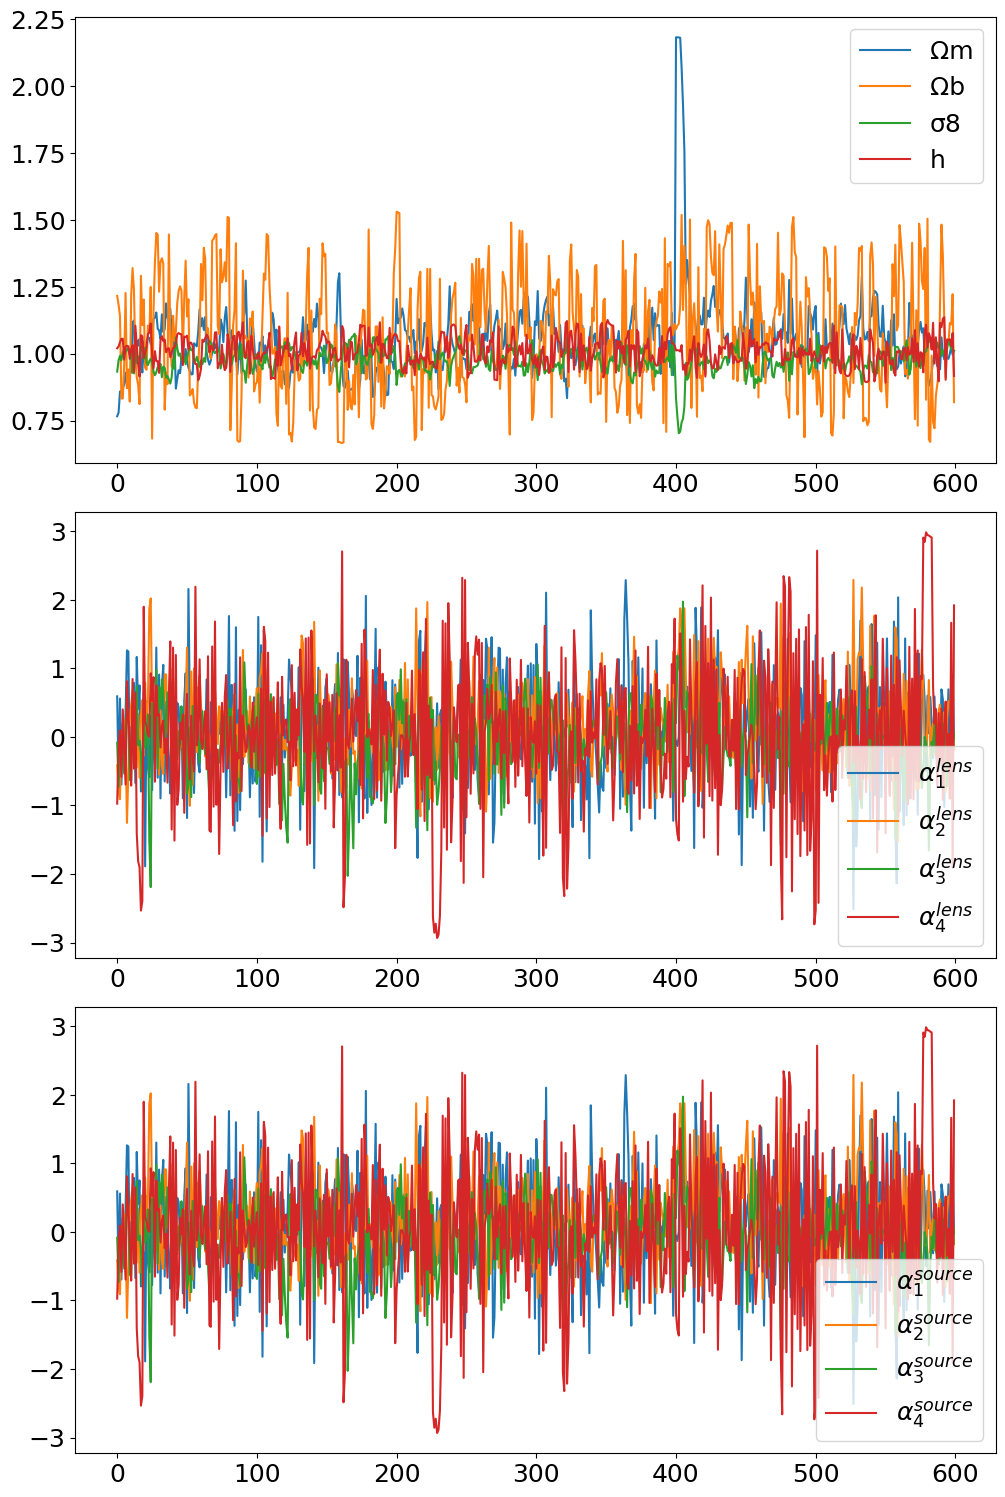

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
chain = chain_3x2_nuisance_gp_num
# First plot
axs[0].plot(np.array(chain["Ωm"])/0.2734714358876248, label="Ωm")
axs[0].plot(np.array(chain["Ωb"])/0.042170616570847225, label="Ωb")
axs[0].plot(np.array(chain["σ8"])/0.7790071910238021, label="σ8")
axs[0].plot(np.array(chain["h"])/0.7189925511925751, label="h")
axs[0].legend()
# Second plot
axs[1].plot(np.array(chain["alphas_lens_0[1]"]), label=r"$\alpha^{lens}_1$")
axs[1].plot(np.array(chain["alphas_lens_0[2]"]), label=r"$\alpha^{lens}_2$")
axs[1].plot(np.array(chain["alphas_lens_0[3]"]), label=r"$\alpha^{lens}_3$")
axs[1].plot(np.array(chain["alphas_lens_0[4]"]), label=r"$\alpha^{lens}_4$")
axs[1].legend()

# Third plot
axs[2].plot(np.array(chain["alphas_lens_0[1]"]), label=r"$\alpha^{source}_1$")
axs[2].plot(np.array(chain["alphas_lens_0[2]"]), label=r"$\alpha^{source}_2$")
axs[2].plot(np.array(chain["alphas_lens_0[3]"]), label=r"$\alpha^{source}_3$")
axs[2].plot(np.array(chain["alphas_lens_0[4]"]), label=r"$\alpha^{source}_4$")
axs[2].legend()

plt.tight_layout()
plt.show()

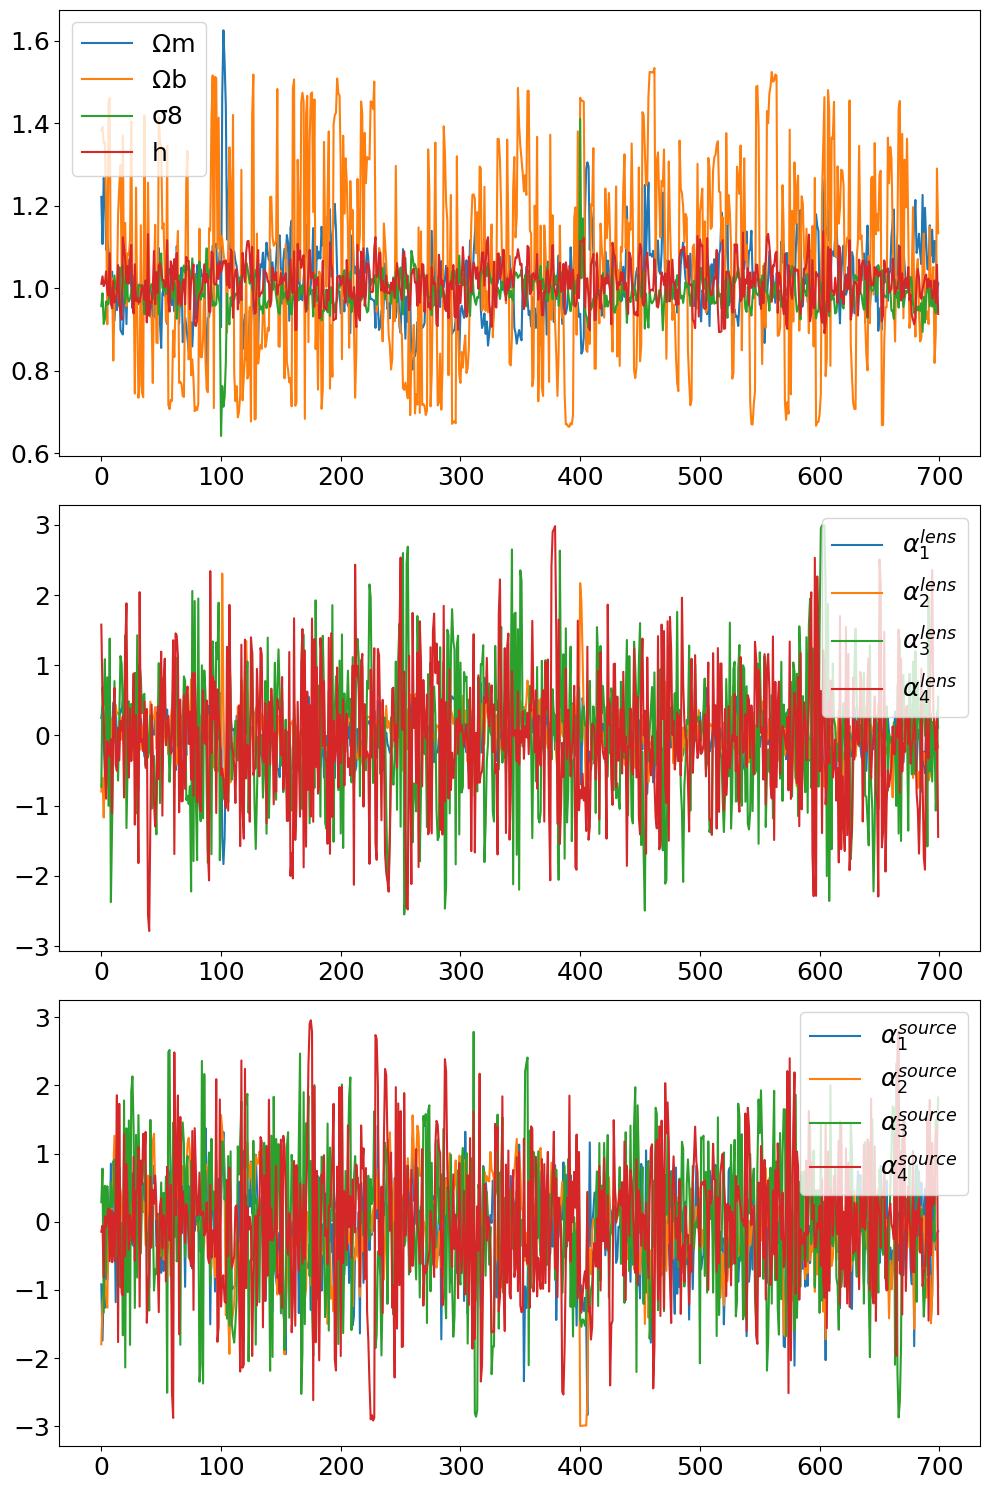

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
chain = chain_3x2_nuisance_dz_num
# First plot
axs[0].plot(np.array(chain["Ωm"])/0.2734714358876248, label="Ωm")
axs[0].plot(np.array(chain["Ωb"])/0.042170616570847225, label="Ωb")
axs[0].plot(np.array(chain["σ8"])/0.7790071910238021, label="σ8")
axs[0].plot(np.array(chain["h"])/0.7189925511925751, label="h")
axs[0].legend()
# Second plot
axs[1].plot(np.array(chain["alphas_lens[1]"]), label=r"$\alpha^{lens}_1$")
axs[1].plot(np.array(chain["alphas_lens[2]"]), label=r"$\alpha^{lens}_2$")
axs[1].plot(np.array(chain["alphas_lens[3]"]), label=r"$\alpha^{lens}_3$")
axs[1].plot(np.array(chain["alphas_lens[4]"]), label=r"$\alpha^{lens}_4$")
axs[1].legend()

# Third plot
axs[2].plot(np.array(chain["alphas_source[1]"]), label=r"$\alpha^{source}_1$")
axs[2].plot(np.array(chain["alphas_source[2]"]), label=r"$\alpha^{source}_2$")
axs[2].plot(np.array(chain["alphas_source[3]"]), label=r"$\alpha^{source}_3$")
axs[2].plot(np.array(chain["alphas_source[4]"]), label=r"$\alpha^{source}_4$")
axs[2].legend()

plt.tight_layout()
plt.show()

## Posteriors

In [15]:
labels_dict = {'h': 'h',
               'Ωm': r'\Omega_m',
               'Ωb': r'\Omega_b',
               'ns': 'n_s',
               'σ8': r'\sigma_8',
               'S8': 'S_8',
               'A_IA': 'A_{IA}',
               'alpha_IA': r'\alpha_{IA}',

               'lens_1_b': r'b_{lens}^{1}',
               'lens_2_b': r'b_{lens}^{2}',
               'lens_3_b': r'b_{lens}^{3}',
               'lens_4_b': r'b_{lens}^{4}',
               'lens_5_b': r'b_{lens}^{5}',
               
               'dzs[1]': r'\Delta^{1}_{z, lens}',
               'dzs[2]': r'\Delta^{2}_{z, lens}',
               'dzs[3]': r'\Delta^{3}_{z, lens}',
               'dzs[4]': r'\Delta^{4}_{z, lens}',
               'dzs[5]': r'\Delta^{5}_{z, lens}',
               'dzs[6]': r'\Delta^{1}_{z, source}',
               'dzs[7]': r'\Delta^{2}_{z, source}',
               'dzs[8]': r'\Delta^{3}_{z, source}',
               'dzs[9]': r'\Delta^{4}_{z, source}',
               'dzs[10]': r'\Delta^{5}_{z, source}', 

               'wzs[1]': r'w^{1}_{z, lens}',
               'wzs[2]': r'w^{1}_{z, lens}',
               'wzs[3]': r'w^{1}_{z, lens}',
               'wzs[4]': r'w^{1}_{z, lens}',
               'wzs[5]': r'w^{1}_{z, lens}',
               'wzs[6]': r'w^{1}_{z, source}',
               'wzs[7]': r'w^{1}_{z, source}',
               'wzs[8]': r'w^{1}_{z, source}',
               'wzs[9]': r'w^{1}_{z, source}',
               'wzs[10]': r'w^{1}_{z, source}',

               'dzs_lens[1]': r'\Delta^{1}_{z, lens}',
               'dzs_lens[2]': r'\Delta^{2}_{z, lens}',
               'dzs_lens[3]': r'\Delta^{3}_{z, lens}',
               'dzs_lens[4]': r'\Delta^{4}_{z, lens}',
               'dzs_lens[5]': r'\Delta^{5}_{z, lens}',
               'dzs_source[1]': r'\Delta^{1}_{z, source}',
               'dzs_source[2]': r'\Delta^{2}_{z, source}',
               'dzs_source[3]': r'\Delta^{3}_{z, source}',
               'dzs_source[4]': r'\Delta^{4}_{z, source}',
               'dzs_source[5]': r'\Delta^{5}_{z, source}', 

               'wzs_lens[1]': r'w^{1}_{z, lens}',
               'wzs_lens[2]': r'w^{1}_{z, lens}',
               'wzs_lens[3]': r'w^{1}_{z, lens}',
               'wzs_lens[4]': r'w^{1}_{z, lens}',
               'wzs_lens[5]': r'w^{1}_{z, lens}',
               'wzs_source[1]': r'w^{1}_{z, source}',
               'wzs_source[2]': r'w^{1}_{z, source}',
               'wzs_source[3]': r'w^{1}_{z, source}',
               'wzs_source[4]': r'w^{1}_{z, source}',
               'wzs_source[5]': r'w^{1}_{z, source}',
               
               'A_IA': 'A_{IA}'}

In [16]:
def make_chain(file, label, ranges=dict({}), weight=False, labels_dict=labels_dict):
    params = np.array(list(file.keys()))
    names = []
    labels = []
    samples = []
    print(label)
    for param in params:
        #print(param)
        if param in labels_dict.keys():
            #print(param)
            names.append(param) 
            labels.append(labels_dict[param]) 
            samples.append(file[param])
    if ('σ8' in params) & ('Ωm' in params):
        #print('S8')
        names.append('S8')
        labels.append(labels_dict['S8'])
        samples.append(file['σ8']*np.sqrt(file['Ωm']/0.3))

    names = np.array(names)
    labels = np.array(labels)
    samples = np.transpose(np.array(samples))
    if weight == True:
        if "log_density" in params:
            print("applying weights")
            ws = np.array(file['log_density'])
    else:
        ws = None
    print("========")

    return MCSamples(samples=samples, names=names, labels=labels, label=label, ranges=ranges, weights=ws,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.3})
    

In [17]:
samples_dz_prior = make_chain(prior_dz_chain, r"Prior - $\Delta_z$ ", labels_dict=labels_dict)
samples_wzdz_prior = make_chain(prior_wzdz_chain, r"Prior - $\Delta_z + w_z$ ", labels_dict=labels_dict)

Prior - $\Delta_z$ 
Removed no burn in
Prior - $\Delta_z + w_z$ 
Removed no burn in


In [18]:
samples_3x2_nuisance_nomarg = make_chain(chain_3x2_nuisance_nomarg, "CosmoDC2 3x2 - Fixed")

CosmoDC2 3x2 - Fixed
Removed no burn in


In [19]:
samples_3x2_nuisance_dz_ana = make_chain(chain_3x2_nuisance_dz_ana, r"CosmoDC2 3x2 - $\Delta_z$ Analytical")
samples_3x2_nuisance_wzdz_ana = make_chain(chain_3x2_nuisance_wzdz_ana, r"CosmoDC2 3x2 - $\Delta_z + w_z$ Analytical")
samples_3x2_nuisance_PCA_ana = make_chain(chain_3x2_nuisance_PCA_ana, r"CosmoDC2 3x2 - PCA Analytical")
samples_3x2_nuisance_gp_ana = make_chain(chain_3x2_nuisance_gp_ana, r"CosmoDC2 3x2 - GP Analytical")

CosmoDC2 3x2 - $\Delta_z$ Analytical
Removed no burn in
CosmoDC2 3x2 - $\Delta_z + w_z$ Analytical
Removed no burn in
CosmoDC2 3x2 - PCA Analytical
Removed no burn in
CosmoDC2 3x2 - GP Analytical
Removed no burn in


In [20]:
samples_3x2_nuisance_dz_num = make_chain(chain_3x2_nuisance_dz_num, r"CosmoDC2 3x2 - $\Delta_z$ Numerical")
samples_3x2_nuisance_wzdz_num = make_chain(chain_3x2_nuisance_wzdz_num, r"CosmoDC2 3x2 - $\Delta_z + w_z$ Numerical")
samples_3x2_nuisance_PCA_num = make_chain(chain_3x2_nuisance_PCA_num, r"CosmoDC2 3x2 - PCA Numerical")#
samples_3x2_nuisance_gp_num = make_chain(chain_3x2_nuisance_gp_num, r"CosmoDC2 3x2 - GP Numerical")

CosmoDC2 3x2 - $\Delta_z$ Numerical
Removed no burn in
CosmoDC2 3x2 - $\Delta_z + w_z$ Numerical
Removed no burn in
CosmoDC2 3x2 - PCA Numerical
Removed no burn in
CosmoDC2 3x2 - GP Numerical
Removed no burn in


In [21]:
prat_markers = {'h': 0.7189925511925751,
               'Ωm': 0.2734714358876248,
               'Ωb': 0.042170616570847225,
               'ns': 0.9965136823002241,
               'σ8': 0.7790071910238021,
               'lens_1_b':0.879118,
               'lens_2_b':1.05894, 
               'lens_3_b':1.22145, 
               'lens_4_b':1.35065, 
               'lens_5_b':1.58909,
               'A_IA':0.25179439}
prat_markers['S8'] = prat_markers['σ8']*np.sqrt(prat_markers['Ωm']/0.3)

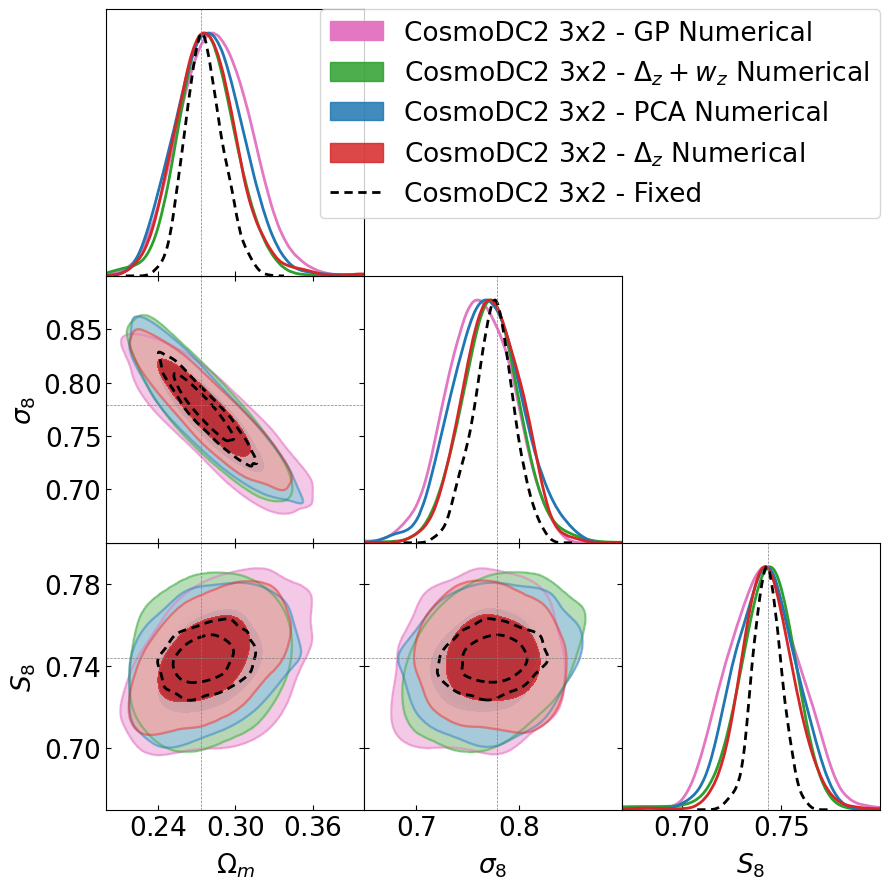

In [22]:
g = plots.getSubplotPlotter(subplot_size=3)
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.triangle_plot([
    samples_3x2_nuisance_gp_num,
    samples_3x2_nuisance_wzdz_num,
    samples_3x2_nuisance_PCA_num,
    samples_3x2_nuisance_dz_num,
    samples_3x2_nuisance_nomarg,
    ],
    ['Ωm', 'σ8', 'S8'],
    #'lens_1_b', 'lens_2_b', 'lens_3_b', 'lens_4_b', 'lens_5_b',],
    line_args=[
            {'color':'C6'},
            {'color':'C2'},
            {'color':'C10'},
            {'color':'C3'},
            {'color':'black'}], 
    colors=['C6', 'C2', 'C10', 'C3', "black"],
    param_limits={'Ωm':(0.2, 0.4), 'σ8':(0.65, 0.9), 'S8':(0.67, 0.8)},
    filled=[True, True, True, True, False],
    contour_ls=['-', '-', '-', '-', '--'], 
    contour_lws=2,
    markers=prat_markers)
g.export("./paper_plots/triangle_comp.pdf")

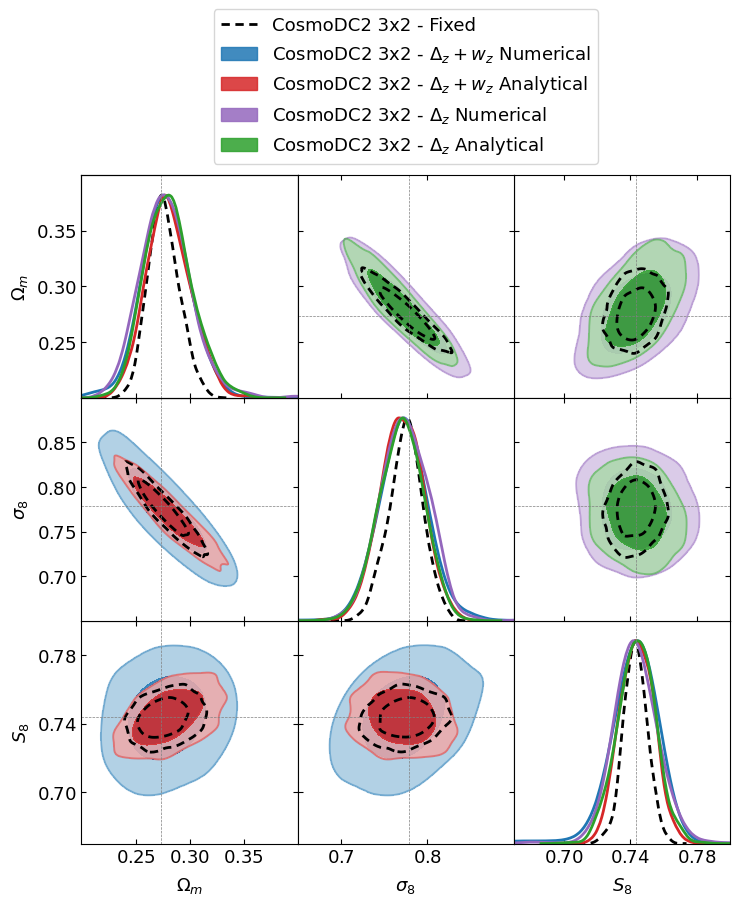

In [23]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.settings.axes_fontsize = 15
g.settings.legend_fontsize = 15
g.settings.axes_labelsize = 15
g.triangle_plot([samples_3x2_nuisance_nomarg,
                 samples_3x2_nuisance_wzdz_num,
                 samples_3x2_nuisance_wzdz_ana,
                 ],
                 ['Ωm', 'σ8', 'S8'],
                 upper_roots = [samples_3x2_nuisance_nomarg,
                                samples_3x2_nuisance_dz_num,
                                samples_3x2_nuisance_dz_ana,
                                ],
                 upper_kwargs = {'contour_colors':['black', 'C4', 'C2'],
                                'contour_ls': ['--', '-', '-'], 
                                    'filled': [False, True, True],
                                    'contour_lws':2}, 
                line_args=[{'color':'black'},
                           {'color':'C10'},
                           {'color':'C3'}], 
                colors=["black", 'C10', 'C3'],
                param_limits={'Ωm':(0.2, 0.4), 'σ8':(0.65, 0.9), 'S8':(0.67, 0.8)},
                filled=[False, True, True],
                contour_ls=['--', '-', '-'], 
                contour_lws=2,
                legend_ncol=1,
                 markers=prat_markers)
g.export("./paper_plots/triangle_1.pdf")

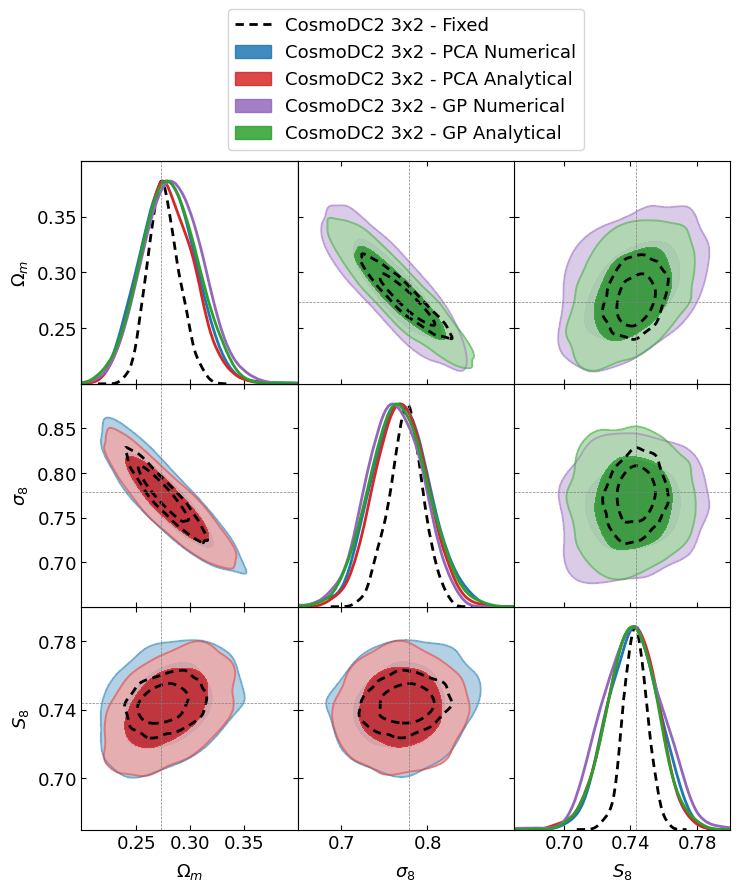

In [24]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.settings.axes_fontsize = 15
g.settings.legend_fontsize = 15
g.settings.axes_labelsize = 15
g.triangle_plot([samples_3x2_nuisance_nomarg,
                 samples_3x2_nuisance_PCA_num,
                 samples_3x2_nuisance_PCA_ana,
                 ],
                 ['Ωm', 'σ8', 'S8'],
                 upper_roots = [samples_3x2_nuisance_nomarg,
                                samples_3x2_nuisance_gp_num,
                                samples_3x2_nuisance_gp_ana,
                                ],
                 upper_kwargs = {'contour_colors':['black', 'C4', 'C2'],
                                'contour_ls': ['--', '-', '-'], 
                                    'filled': [False, True, True],
                                    'contour_lws':2}, 
                line_args=[{'color':'black'},
                           {'color':'C10'},
                           {'color':'C3'}], 
                colors=["black", 'C10', 'C3'],
                param_limits={'Ωm':(0.2, 0.4), 'σ8':(0.65, 0.9), 'S8':(0.67, 0.8)},
                filled=[False, True, True],
                contour_ls=['--', '-', '-'], 
                contour_lws=2,
                legend_ncol=1,
                 markers=prat_markers)
g.export("./paper_plots/triangle_2.pdf")

## Shifts and Widths

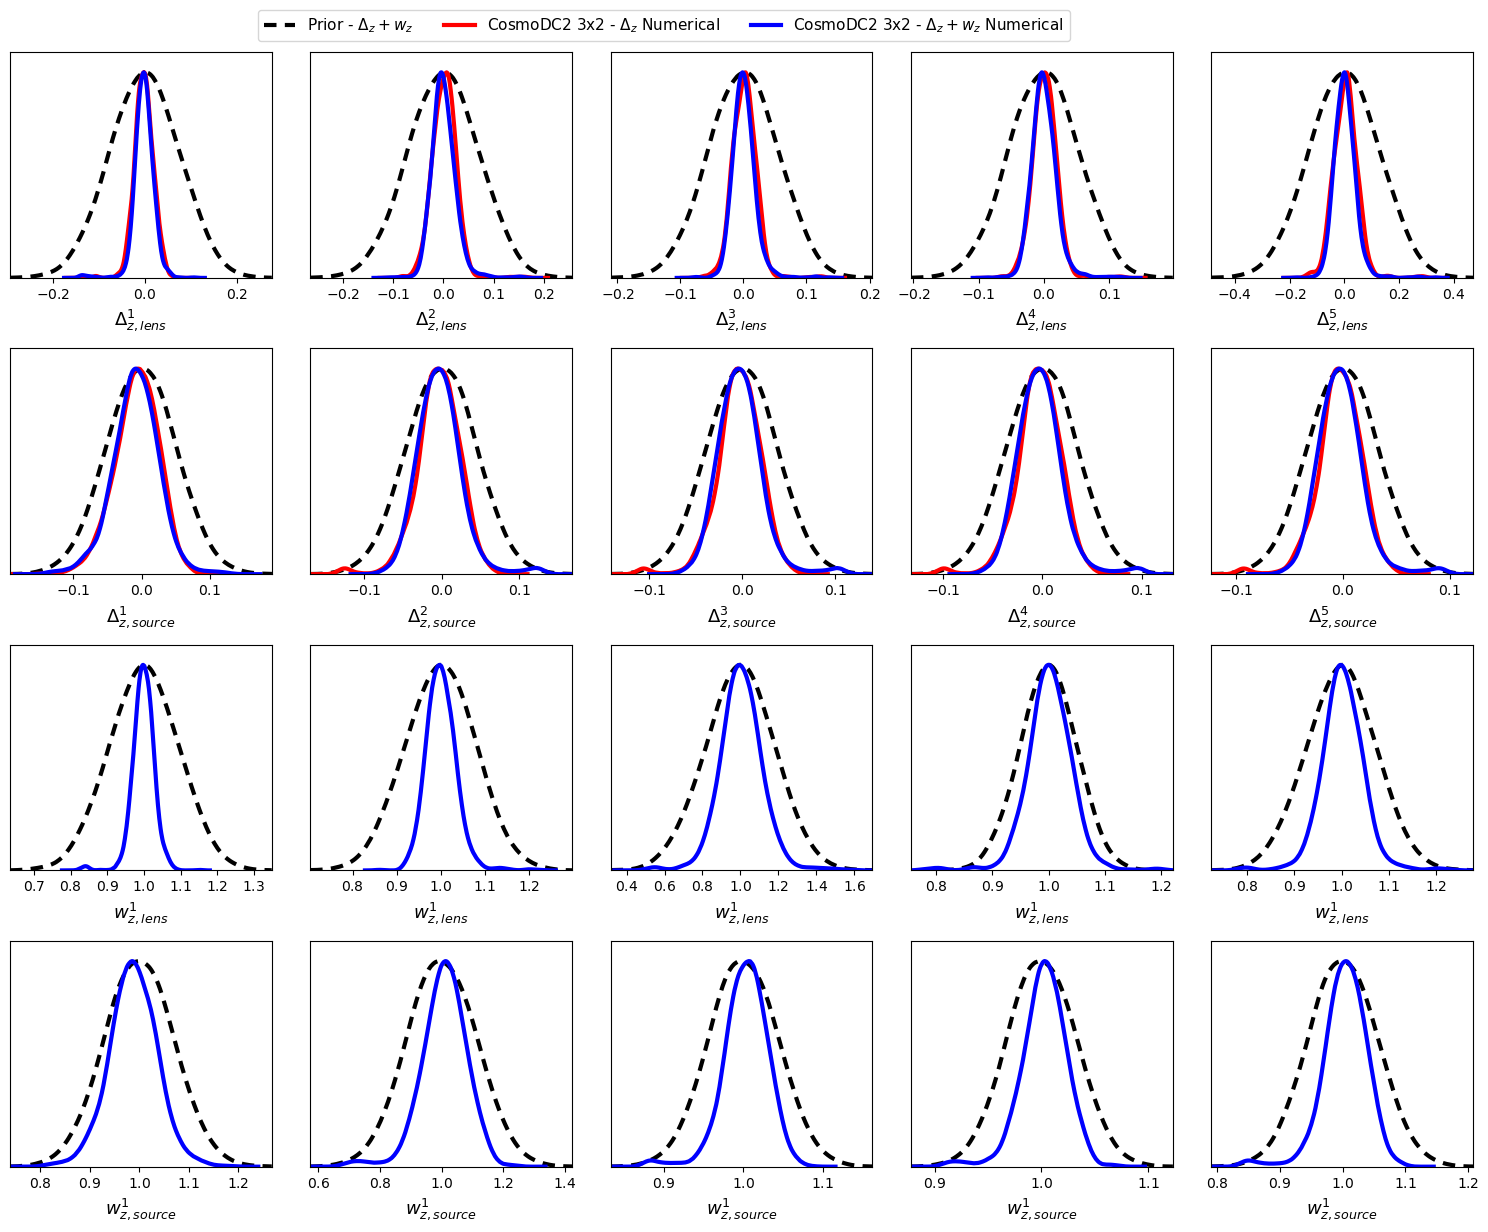

In [25]:
g = plots.get_subplot_plotter(width_inch=15)
g.plots_1d([samples_wzdz_prior,
            samples_3x2_nuisance_dz_num,
            samples_3x2_nuisance_wzdz_num], 
           ['dzs_lens[1]', 'dzs_lens[2]', 'dzs_lens[3]', 'dzs_lens[4]', 'dzs_lens[5]',
            'dzs_source[1]', 'dzs_source[2]', 'dzs_source[3]', 'dzs_source[4]', 'dzs_source[5]',
            'wzs_lens[1]', 'wzs_lens[2]', 'wzs_lens[3]', 'wzs_lens[4]', 'wzs_lens[5]',
            'wzs_source[1]', 'wzs_source[2]', 'wzs_source[3]', 'wzs_source[4]', 'wzs_source[5]'],
            lws=3, ls=['--', '-', '-'], nx=5, legend_ncol=3);

g.export("./paper_plots/wzdz.pdf")

## Nzs

In [ ]:
import nz_prior as nzp

gp_nzs = {}
for tracer_name in list(s_3x2.tracers.keys()):
    nz = nzs[tracer_name]
    nz_mean = nz["dndz"]
    z = nz["z"]
    W = nz["w"] 
    _nzs = np.array([nzp.linear_model(nz_mean, W) for i in range(500)])
    gp_nzs[tracer_name] = [z, _nzs]

## Likelihood

In [26]:
lkl_3x2_nomarg   = np.transpose(np.transpose(np.array(chain_3x2_nuisance_nomarg))[14:622])
xi2_3x2_nomarg  = np.array(chain_3x2_nuisance_nomarg['lp'])

In [27]:
lkl_3x2_nomarg_m, lkl_3x2_nomarg_s   = np.mean(lkl_3x2_nomarg, axis=1), np.std(lkl_3x2_nomarg, axis=1)

In [28]:
lkl_3x2_nomarg_cles  = [pacc.ClTheoryEnsemble(cle_3x2,  np.array(lkl_3x2_nomarg[i]))  for i in range(len(lkl_3x2_nomarg))]

In [29]:
sel_3x2  = np.random.choice(len(lkl_3x2_nomarg), 100)

In [30]:
cross_pairs =  [['source_0', 'lens_0'],
 ['source_0', 'lens_1'],
 ['source_0', 'lens_2'],
 ['source_0', 'lens_3'],
 ['source_0', 'lens_4'],
 ['source_1', 'lens_0'],
 ['source_1', 'lens_1'],
 ['source_1', 'lens_2'],
 ['source_1', 'lens_3'],
 ['source_1', 'lens_4'],
 ['source_2', 'lens_0'],
 ['source_2', 'lens_1'],
 ['source_2', 'lens_2'],
 ['source_2', 'lens_3'],
 ['source_2', 'lens_4'],
 ['source_3', 'lens_0'],
 ['source_3', 'lens_1'],
 ['source_3', 'lens_2'],
 ['source_3', 'lens_3'],
 ['source_3', 'lens_4'],
 ['source_4', 'lens_0'],
 ['source_4', 'lens_1'],
 ['source_4', 'lens_2'],
 ['source_4', 'lens_3'],
 ['source_4', 'lens_4']]

In [31]:
#g = pacc.plot_cls([[cle_3x2], lkl_3x2_nomarg_cles], cle_3x2.pairs,
#                configs=[
#                    {"colors":['black'], "show_legend":False},
#                    {"alpha":0.8, "Xi2s":-xi2_3x2_nomarg[sel_3x2],
#                    "show_legend":False, "show_colobar":True}])
#g.savefig("./paper_plots/validation_3x2.pdf", bbox_inches='tight')